In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder


In [252]:
# loading data
df = pd.read_csv('./data/StudentPerformance.csv')  
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [253]:
df.shape

(10000, 6)

In [254]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


In [255]:
df.describe()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,6.530600,4.583300,55.224800
std,2.589309,17.343152,1.695863,2.867348,19.212558
min,1.000000,40.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000


In [256]:
df.isnull().sum()

Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64

In [257]:
# check and remove duplicates
duplicates = df.duplicated().sum()
df = df.drop_duplicates()

In [258]:
df.shape

(9873, 6)

In [259]:
#seperating numerical and categoricla columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print("Numerical Columns:", num_cols)
print("Categorical Columns:", categorical_cols)

Numerical Columns: ['Hours Studied', 'Previous Scores', 'Sleep Hours', 'Sample Question Papers Practiced', 'Performance Index']
Categorical Columns: ['Extracurricular Activities']


In [260]:
#seperating continous and discrete data
continuous_cols = []
discrete_cols = []
for col in num_cols:
    unique_values = df[col].nunique()
    if unique_values < 20:
        discrete_cols.append(col)
    else:
        continuous_cols.append(col)
        
print("Continuous Columns:", continuous_cols)
print("Discrete Columns:", discrete_cols)

Continuous Columns: ['Previous Scores', 'Performance Index']
Discrete Columns: ['Hours Studied', 'Sleep Hours', 'Sample Question Papers Practiced']


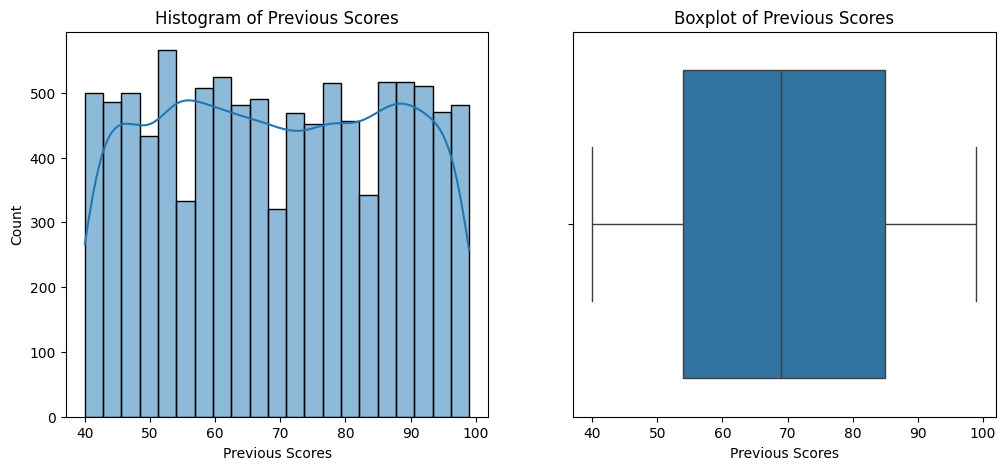

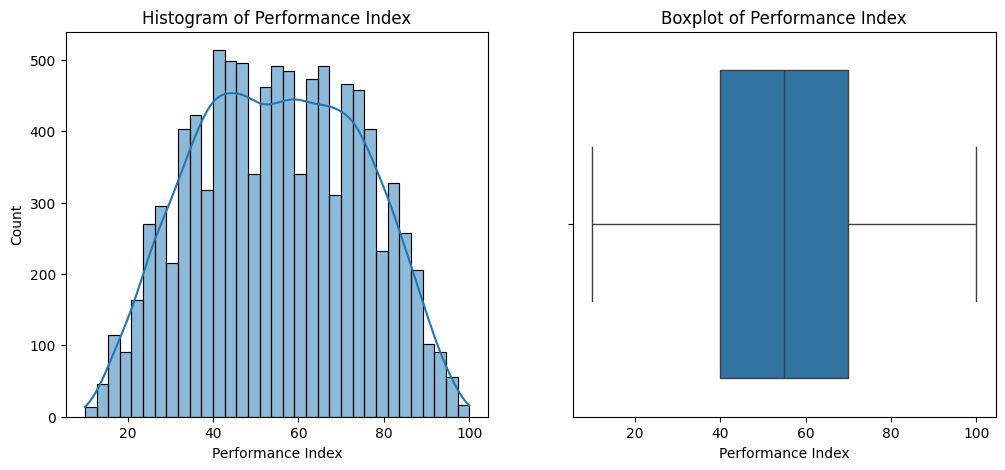

In [261]:
# performing univariate analysis in continuous_cols:
for col in continuous_cols:
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Histogram of {col}')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    
    plt.show()

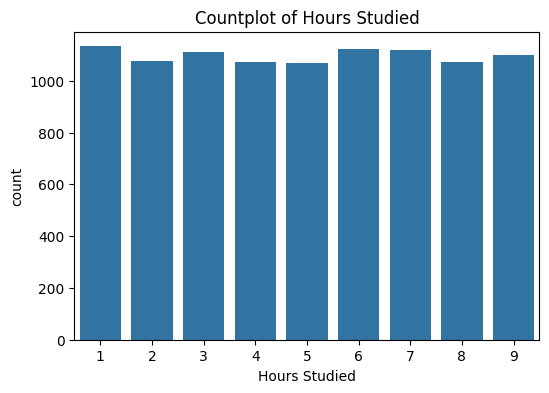

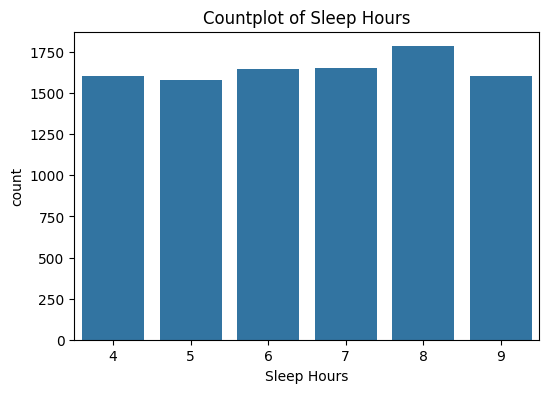

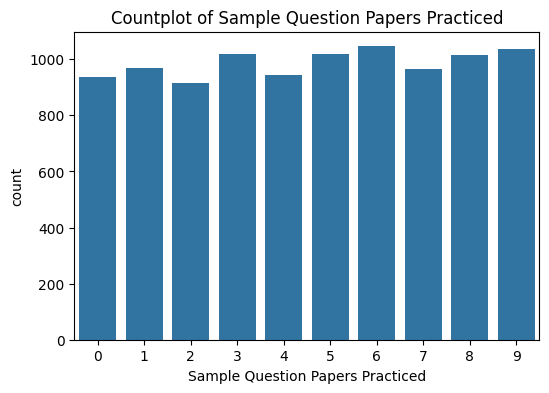

In [262]:
# performing univariate analysis in discrete_cols:
for col in discrete_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=df[col])
    plt.title(f'Countplot of {col}')
    plt.show()

Text(0.5, 1.0, 'Countplot of Extracurricular Activities')

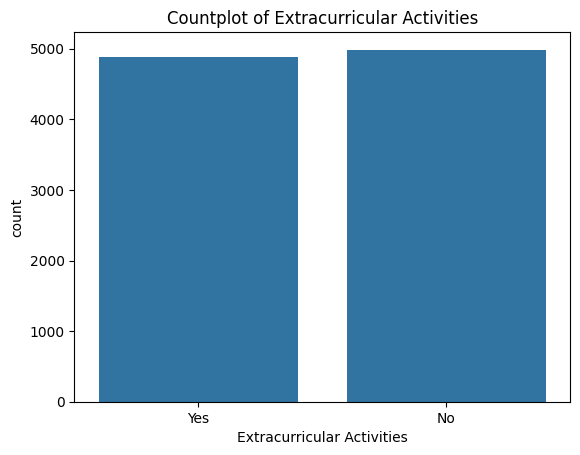

In [263]:
sns.countplot(x=df['Extracurricular Activities'])
plt.title('Countplot of Extracurricular Activities')

In [264]:
# IQR for outlier detection of categorial columns
for col in continuous_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    print(f'Outliers in {col}: {outlier.shape[0]}')

Outliers in Previous Scores: 9873
Outliers in Performance Index: 9873


`Interpretation`: No Missing-Value, removed duplicated data, Checked for outliers, Checked for distribution of variable in given dataset. When, we checked the outlier for continous variable, no outlier present. Now, we will encode the data, to make sure it is ready to train our logistic regression.

## Encoding

In [265]:
# One hot encoding
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_cols = encoder.fit_transform(df[categorical_cols])
df = df.drop(columns=categorical_cols)
encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(categorical_cols))
df = pd.concat([df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

In [266]:
# Scaling the numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(df[num_cols])
df[num_cols] = scaled



In [267]:
df.head()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index,Extracurricular Activities_Yes
0,0.775566,1.706168,1.454025,-1.249715,1.862979,1.0
1,-0.383205,0.724912,-1.491315,-0.900925,0.509348,0.0
2,1.161822,-1.064438,0.275889,-0.900925,-0.531907,1.0
3,0.003052,-1.006717,-0.902247,-0.900925,-1.000471,1.0
4,0.775566,0.320865,0.864957,0.145444,0.561411,0.0


## Correlation Matrix

Text(0.5, 1.0, 'Correlation Matrix')

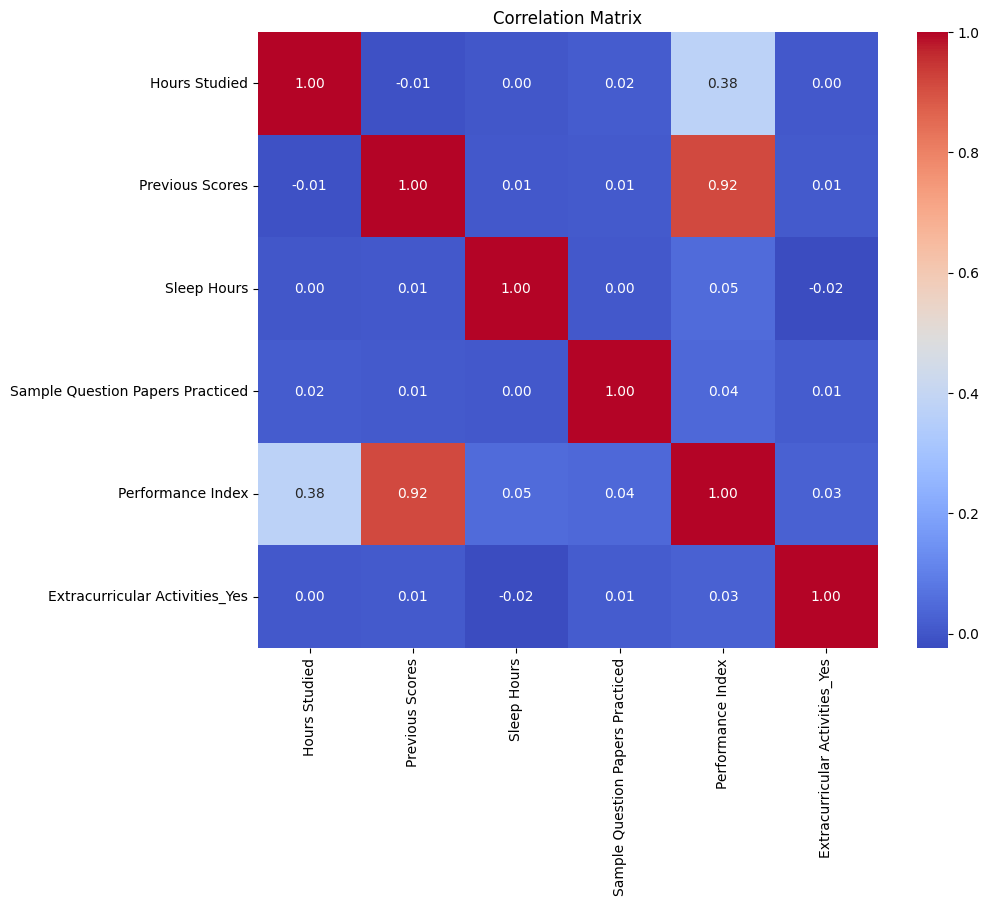

In [268]:
corr = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')

In [269]:
df.head()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index,Extracurricular Activities_Yes
0,0.775566,1.706168,1.454025,-1.249715,1.862979,1.0
1,-0.383205,0.724912,-1.491315,-0.900925,0.509348,0.0
2,1.161822,-1.064438,0.275889,-0.900925,-0.531907,1.0
3,0.003052,-1.006717,-0.902247,-0.900925,-1.000471,1.0
4,0.775566,0.320865,0.864957,0.145444,0.561411,0.0


## Training Test Split

In [270]:
# training test split
X = df.drop('Extracurricular Activities_Yes', axis=1)
y = df['Extracurricular Activities_Yes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Logistic Regression

In [271]:
# training model
model = LogisticRegression()
model.fit(X_train, y_train)
# making predictions
y_pred = model.predict(X_test)

## Evaluating Model

In [272]:
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.59      0.58      0.58      1013
         1.0       0.57      0.59      0.58       962

    accuracy                           0.58      1975
   macro avg       0.58      0.58      0.58      1975
weighted avg       0.58      0.58      0.58      1975



In [273]:
# evaluating model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 58.03%


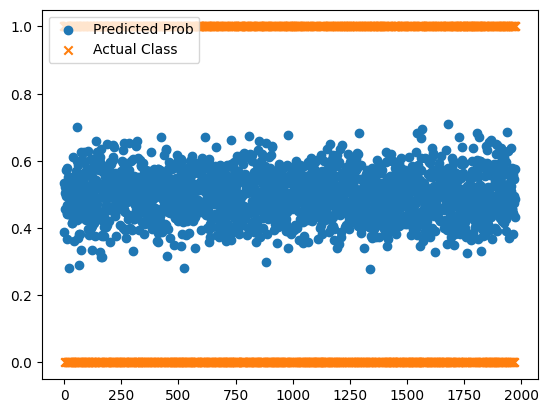

In [274]:
probs = model.predict_proba(X_test)[:,1]

plt.scatter(range(len(y_test)), probs, label="Predicted Prob", marker='o')
plt.scatter(range(len(y_test)), y_test, label="Actual Class", marker='x')
plt.legend()
plt.show()

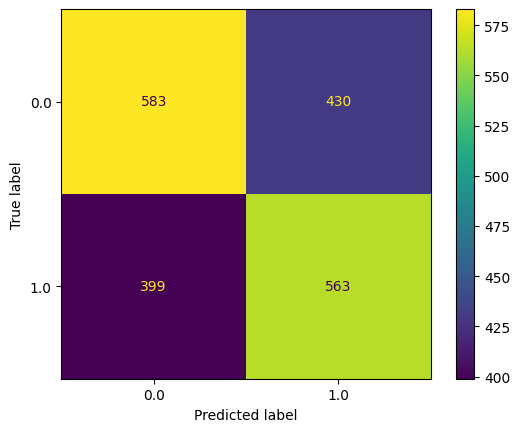

In [275]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.show()

## Visualizing Prediction

<Axes: ylabel='Extracurricular Activities_Yes'>

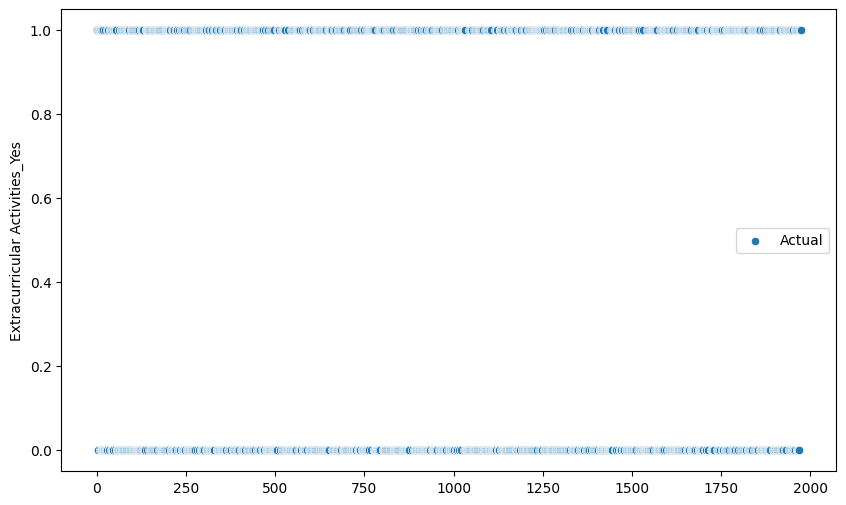

In [276]:
# Visualizing Prediction along with actual values
plt.figure(figsize=(10,6))
sns.scatterplot(x=range(len(y_test)), y=y_test, label='Actual')
